# Burster Izhikevich - Segregated Pipeline

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 46
num_slices_new = 10
num_slices_old = 5
# num of expected jobs: 6555
cell_props = "low" # low, high, center
experiment = "range" # blocked, range
experiment_folder = f"output/bursterIzh_seg_individual_{cell_props}_{experiment}_sl-{num_slices_new}-{num_slices_old}/{random_seed}"
#experiment_folder = f"output/bursterIzh_seg_surfaceTest_sl-{num_slices_new}/{random_seed}"
target_folder = experiment_folder + "/target"

# module 1 is for spiking, module 2 for bursting, final for refining all channels

module_1_folder = experiment_folder + "/module_1"
module_2_folder = experiment_folder + "/module_2"
module_3_folder = experiment_folder + "/module_3"
module_4_folder = experiment_folder + "/module_4"
module_final_folder = experiment_folder + "/module_final"

# We need to order the ion channels according to V1/2:
# im: -52.7
# kdr: 13
# na3: -30 (act), -45 (inact)
# nap: -48
# In order: leak, im, nap, na3, kdr

target_cell = TargetCell(
    hoc_file=f"/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_{cell_props}{experiment}/seg/template.hoc",
    mod_folder=f"/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_{cell_props}{experiment}/seg",
    cell_name="Burster_Izh",
    g_names = ["gmbar_im", "gbar_nap", "gbar_na3", "gkdrbar_kdr", "glbar_leak"]
)

sim_par= SimParams(
            h_v_init=-67.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.3,0.5],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


# Generate Synthetic Data

In [2]:
sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

Blocking: []
Total number of jobs: 3
Total number of proccessors: 192


/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/target/synthetic_0.1_0.3_0.5_


In [3]:
#import matplotlib.pyplot as plt
#import numpy as np

#data = np.load("/home/mwsrgf/proj/ACT/output/bursterIzh_seg_filtered_sl-10/42/module_1/train/combined_out.npy")

#Volt = data[:,:,0]

#plt.plot(Volt[1,:])

In [4]:
passive_sim_par = SimParams(
            h_v_init = -67,
            h_tstop = 1500,
            h_dt = 0.001,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 1000,
            CI_delay = 500,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/target/synthetic_-1_


# Get Passive Properties

In [5]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file=f"/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_{cell_props}{experiment}/seg/template.hoc",
    mod_folder=f"/home/mwsrgf/proj/ACT/data/Burster_Izhikevich_{cell_props}{experiment}/seg",
    cell_name="Burster_Izh",
    g_names = ["gmbar_im", "gbar_nap", "gbar_na3", "gkdrbar_kdr", "glbar_leak"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"{target_folder}/passive_data.csv",
    leak_conductance_variable="glbar_leak",
    leak_reversal_variable="el_leak"
)

In [6]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-70.14514870464808, R_in=408.43451510871887, tau=92.56, Cm=2.5000591182230965, g_bar_leak=2.7010146048218414e-05, cell_area=9.064641486925113e-05, leak_conductance_variable='glbar_leak', leak_reversal_variable='el_leak')


## Run Module 1 im

In [7]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod1 = ACTModule(
    ModuleParameters(
        module_folder_name=module_1_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gmbar_im", low=0.0019, high=0.0057, n_slices=num_slices_new),
                OptimizationParam(param="gbar_nap", low=0.0002, high=0.0006, n_slices=1),
                OptimizationParam(param="gbar_na3", low=0.025, high=0.075, n_slices=1),
                OptimizationParam(param="gkdrbar_kdr", low=0.015, high=0.045, n_slices=1),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            #filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            saturation_threshold=-55,
            window_of_inspection=(120,400),
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{module_1_folder}/results/saved_metrics.json"
        )
    )
)

In [8]:
predicted_g_data_file = mod1.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 30
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/module_1/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough Time 13', 'Trough Time 14', 'Trough Time 1

In [9]:
mod1.pickle_rf(mod1.rf_model,f"{module_1_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gmbar_im': 0.0032929111111111254, 'gbar_nap': 0.00040000000000000734, 'gbar_na3': 0.049999999999999295, 'gkdrbar_kdr': 0.03000000000000038, 'glbar_leak': 2.7010146048218777e-05}


## Run Module 2 kdr

In [10]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# Allow all channels to vary by 20% their predicted value in the previous module
bounds_variation = 0.15

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod2 = ACTModule(
    ModuleParameters(
        module_folder_name=module_2_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices = [
                OptimizationParam(param="gmbar_im", prediction=train_cell.predicted_g["gmbar_im"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_nap", low=0.0002, high=0.0006, n_slices=num_slices_new),
                OptimizationParam(param="gbar_na3", low=0.025, high=0.075, n_slices=1),
                OptimizationParam(param="gkdrbar_kdr", low=0.015, high=0.045, n_slices=1),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            #filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            saturation_threshold=-55,
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{module_2_folder}/results/saved_metrics.json"
        )
    )
)

In [11]:
predicted_g_data_file = mod2.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 150
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/module_2/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough Time 13', 'Trough Time 14', 'Trough Time 

In [12]:
mod2.pickle_rf(mod2.rf_model,f"{module_2_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gmbar_im': 0.0035411142861110846, 'gbar_nap': 0.00043577777777777647, 'gbar_na3': 0.049999999999999295, 'gkdrbar_kdr': 0.03000000000000038, 'glbar_leak': 2.7010146048218777e-05}


# Module 3 na3

In [13]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# Allow all channels to vary by 20% their predicted value in the previous module
bounds_variation = 0.15

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod3 = ACTModule(
    ModuleParameters(
        module_folder_name=module_3_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices = [
                OptimizationParam(param="gmbar_im", prediction=train_cell.predicted_g["gmbar_im"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_nap", prediction=train_cell.predicted_g["gbar_nap"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_na3", low=0.025, high=0.075, n_slices=num_slices_new),
                OptimizationParam(param="gkdrbar_kdr", low=0.015, high=0.045, n_slices=1),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            #filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            saturation_threshold=-55,
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{module_3_folder}/results/saved_metrics.json"
        )
    )
)

In [14]:
predicted_g_data_file = mod3.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 750
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/module_3/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough Time 13', 'Trough Time 14', 'Trough Time 

In [15]:
mod3.pickle_rf(mod3.rf_model,f"{module_3_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gmbar_im': 0.003651862635409213, 'gbar_nap': 0.00038940012777777917, 'gbar_na3': 0.036116666666666936, 'gkdrbar_kdr': 0.03000000000000038, 'glbar_leak': 2.7010146048218777e-05}


# Module 4 kdr

In [16]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

# Allow all channels to vary by 20% their predicted value in the previous module
bounds_variation = 0.15

# gmbar_im = 0.0038, gkdrbar_kdr= 0.03, gbar_nap= 0.0004, gbar_na3= 0.05, glbar_leak= 3.6e-5
mod4 = ACTModule(
    ModuleParameters(
        module_folder_name=module_4_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices = [
                OptimizationParam(param="gmbar_im", prediction=train_cell.predicted_g["gmbar_im"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_nap", prediction=train_cell.predicted_g["gbar_nap"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_na3", prediction=train_cell.predicted_g["gbar_na3"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gkdrbar_kdr", low=0.015, high=0.045, n_slices=num_slices_new),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            #filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            saturation_threshold=-55,
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{module_4_folder}/results/saved_metrics.json"
        )
    )
)

In [17]:
predicted_g_data_file = mod4.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 3750
Total number of proccessors: 192


MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/module_4/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough Time 13', 'Trough Time 14', 'Trough Time 15', 'Trough Time 16', 'Trough Time 17', 'Trough Time 18', 'Trough Time 19', 'Trough Time 20', 'Min Trough Height', 'Max Trou

In [18]:
mod4.pickle_rf(mod4.rf_model,f"{module_4_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gmbar_im': 0.003509713882325915, 'gbar_nap': 0.00036200582878861146, 'gbar_na3': 0.03631440541666724, 'gkdrbar_kdr': 0.020936666666666815, 'glbar_leak': 2.7010146048218777e-05}


## Run Fine Tuning Module

In [19]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

bounds_variation = 0.15

final_mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_final_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices = [
                OptimizationParam(param="gmbar_im", prediction=train_cell.predicted_g["gmbar_im"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_nap", prediction=train_cell.predicted_g["gbar_nap"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gbar_na3", prediction=train_cell.predicted_g["gbar_na3"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="gkdrbar_kdr", prediction=train_cell.predicted_g["gkdrbar_kdr"], bounds_variation=bounds_variation, n_slices=num_slices_old),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            #filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
            spike_threshold=0,
            saturation_threshold=-55,
            first_n_spikes=20,
            prediction_eval_method='fi_curve',
            random_state=random_seed,
            save_file=f"{module_final_folder}/results/saved_metrics.json"
        )
    )
)

In [20]:
final_predicted_g_data_file = final_mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 1875
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/bursterIzh_seg_individual_low_range_sl-10-5/46/module_final/train
TRAINING RANDOM FOREST REGRESSOR
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spike Height', 'Max Spike Height', 'Avg Spike Height', 'Std Spike Height', 'Trough Time 1', 'Trough Time 2', 'Trough Time 3', 'Trough Time 4', 'Trough Time 5', 'Trough Time 6', 'Trough Time 7', 'Trough Time 8', 'Trough Time 9', 'Trough Time 10', 'Trough Time 11', 'Trough Time 12', 'Trough Time 13', 'Trough Time 14', 'Trough 

In [21]:
final_mod.pickle_rf(final_mod.rf_model,f"{module_final_folder}/trained_rf.pkl")
print(train_cell.predicted_g)

{'gmbar_im': 0.003210423031010629, 'gbar_nap': 0.00034392363764062134, 'gbar_na3': 0.03658131629648011, 'gkdrbar_kdr': 0.019262780166667007, 'glbar_leak': 2.7010146048218777e-05}


# Results & Metrics

In [22]:
from act import ACTPlot
ACTPlot.plot_v_comparison(
    final_predicted_g_data_file, 
    module_final_folder, 
    sim_par["CI_amps"],
    sim_par["h_dt"]
    )

ACTPlot.plot_fi_comparison(
    module_final_folder, 
    sim_par["CI_amps"]
    )

In [23]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.save_interspike_interval_comparison(
    module_final_folder,
    final_predicted_g_data_file,
    sim_par["CI_amps"], 
    sim_par["h_dt"],
    first_n_spikes=5,
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

# HighRange
#actual_g={"gbar_na3": 0.065, "gkdrbar_kdr": 0.043,"gbar_nap": 0.00055,"gmbar_im": 0.0053, "glbar_leak": 4.5e-5},
# CenterRange
#actual_g={"gbar_na3": 0.05, "gkdrbar_kdr": 0.03,"gbar_nap": 0.0004,"gmbar_im": 0.0038, "glbar_leak": 3.6e-5},
# LowRange
#actual_g={"gbar_na3": 0.035, "gkdrbar_kdr": 0.017,"gbar_nap": 0.00025,"gmbar_im": 0.0023, "glbar_leak": 2.7e-5},
if cell_props == "low":
    actual_g={"gbar_na3": 0.035, "gkdrbar_kdr": 0.017,"gbar_nap": 0.00025,"gmbar_im": 0.0023, "glbar_leak": 2.7e-5}
elif cell_props == "center":
    actual_g={"gbar_na3": 0.05, "gkdrbar_kdr": 0.03,"gbar_nap": 0.0004,"gmbar_im": 0.0038, "glbar_leak": 3.6e-5}
elif cell_props == "high":
    actual_g={"gbar_na3": 0.065, "gkdrbar_kdr": 0.043,"gbar_nap": 0.00055,"gmbar_im": 0.0053, "glbar_leak": 4.5e-5} 
    
metrics.save_prediction_g_mae(
    actual_g=actual_g,
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

metrics.save_feature_mae(
    module_final_folder,
    final_predicted_g_data_file,
    ["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
    sim_par["h_dt"],
    first_n_spikes=5,
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)


Interspike times (Target): [[2.830e+01 2.334e+02 1.000e+06 1.000e+06]
 [2.020e+01 2.290e+01 1.000e+06 1.000e+06]
 [1.720e+01 1.770e+01 2.090e+01 1.984e+02]]
Interspike times (Prediction): [[2.470e+01 2.238e+02 1.000e+06 1.000e+06]
 [1.910e+01 2.170e+01 1.000e+06 1.000e+06]
 [1.650e+01 1.720e+01 2.150e+01 2.297e+02]]
MAE for each I injection: [3.29999999999999, 0.5750000000000064, 8.275000000000013]
Mean interspike-interval MAE: 4.050000000000003
Standard Deviation interspike-interval MAE: 3.1879329771290195
MAE of final g prediction: 0.02034795198810882
MAE of summary features for final prediction: 1.221343496000452


# Feature MAE

Smallest MAE values (gbar_na3, gkdrbar_kdr, Summary Stats MAE): 
[[2.98325680e-03 3.07704954e-04 4.44007922e-01]
 [2.98325680e-03 3.34855392e-04 4.46954517e-01]
 [2.98325680e-03 3.07704954e-04 4.50033162e-01]
 [2.98325680e-03 3.07704954e-04 4.62180799e-01]
 [2.98325680e-03 3.07704954e-04 4.62257958e-01]
 [2.98325680e-03 3.07704954e-04 4.65434969e-01]]


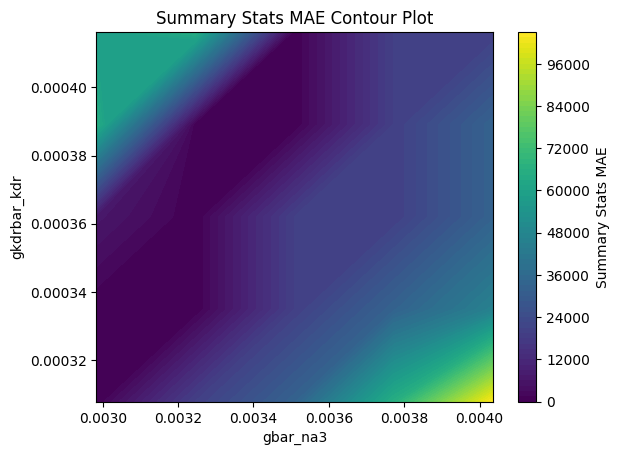

Smallest MAE values (gbar_na3, gbar_nap, Summary Stats MAE): 
[[0.00298326 0.03359083 0.44400792]
 [0.00298326 0.03631441 0.44695452]
 [0.00298326 0.03359083 0.45003316]
 [0.00298326 0.03631441 0.4621808 ]
 [0.00298326 0.03631441 0.46225796]
 [0.00298326 0.03631441 0.46543497]]


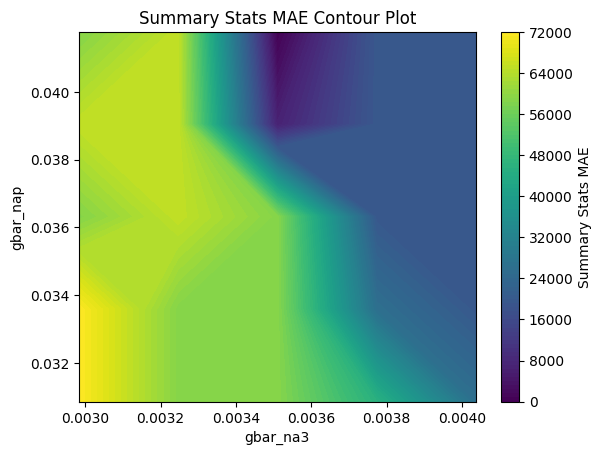

Smallest MAE values (gbar_na3, gmbar_im, Summary Stats MAE): 
[[0.00298326 0.02093667 0.44400792]
 [0.00298326 0.01936642 0.44695452]
 [0.00298326 0.01936642 0.45003316]
 [0.00298326 0.01936642 0.4621808 ]
 [0.00298326 0.02250692 0.46225796]
 [0.00298326 0.02093667 0.46543497]]


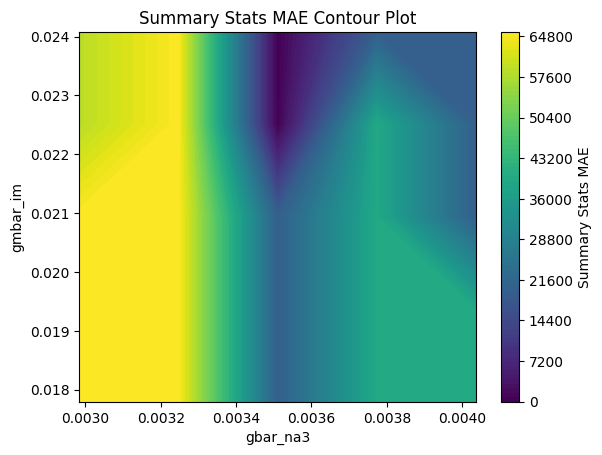

In [24]:
from act import ACTPlot as actplt

g_names = ["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im"]

for i in range(len(g_names)-1):
    actplt.plot_training_feature_mae_contour_plot(
        module_final_folder,
        sim_par["CI_amps"],
        sim_par["CI_delay"],
        sim_par["h_dt"],
        index1=0,
        index2=i+1,
        g_names=g_names,
        train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "trough_times", "trough_height_stats"],
        threshold=0,
        first_n_spikes=20,
        num_levels=100,
        results_filename=f"{module_final_folder}/results/Feature_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )

# FI MAE

Smallest FI MAE values (gbar_na3, gkdrbar_kdr, FI MAE): 
[[0.00298326 0.00036201 0.        ]
 [0.00324649 0.00036201 0.        ]
 [0.00324649 0.00036201 0.        ]
 [0.00324649 0.00036201 0.        ]
 [0.00324649 0.00036201 0.        ]
 [0.00324649 0.00036201 0.        ]]


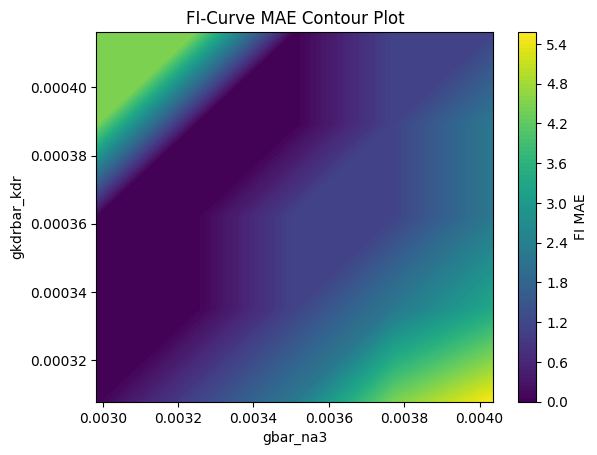

Smallest FI MAE values (gbar_na3, gbar_nap, FI MAE): 
[[0.00298326 0.04176157 0.        ]
 [0.00324649 0.03903799 0.        ]
 [0.00324649 0.03903799 0.        ]
 [0.00324649 0.03903799 0.        ]
 [0.00324649 0.04176157 0.        ]
 [0.00324649 0.04176157 0.        ]]


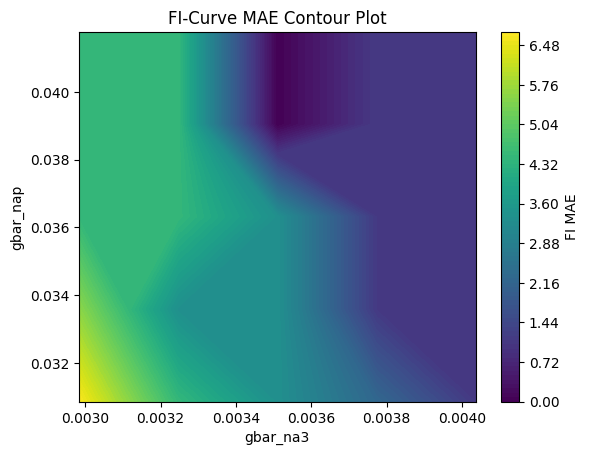

Smallest FI MAE values (gbar_na3, gmbar_im, FI MAE): 
[[0.00298326 0.02250692 0.        ]
 [0.00324649 0.02093667 0.        ]
 [0.00324649 0.02250692 0.        ]
 [0.00324649 0.02407717 0.        ]
 [0.00324649 0.01779617 0.        ]
 [0.00324649 0.01936642 0.        ]]


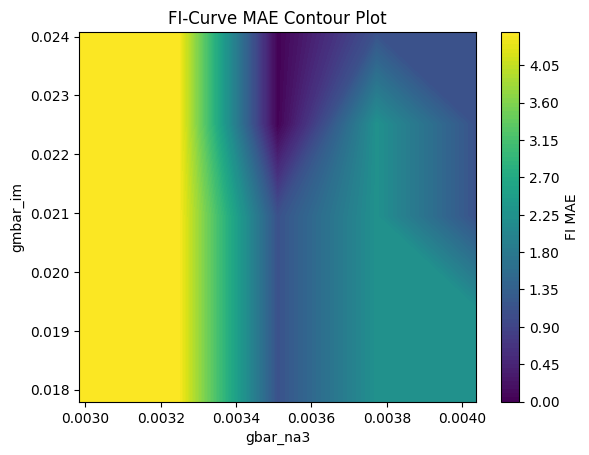

In [25]:
from act import ACTPlot as actplt

g_names = ["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im"]

for i in range(len(g_names)-1):
    actplt.plot_training_fi_mae_contour_plot(
        module_final_folder,
        sim_par["CI_amps"], 
        sim_par["CI_dur"],
        sim_par["CI_delay"],
        sim_par["h_dt"],
        index1=0,
        index2=i+1,
        g_names=g_names,
        results_filename=f"{module_final_folder}/results/FI_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )

# Voltage MAE

Smallest MAE values (gbar_na3, gkdrbar_kdr, V MAE): 
[[2.98325680e-03 3.07704954e-04 1.90908732e+00]
 [2.98325680e-03 3.07704954e-04 1.96484591e+00]
 [2.98325680e-03 3.07704954e-04 2.02478000e+00]
 [2.98325680e-03 3.07704954e-04 2.08831630e+00]
 [2.98325680e-03 3.07704954e-04 2.13087388e+00]
 [2.98325680e-03 3.07704954e-04 2.18739000e+00]]


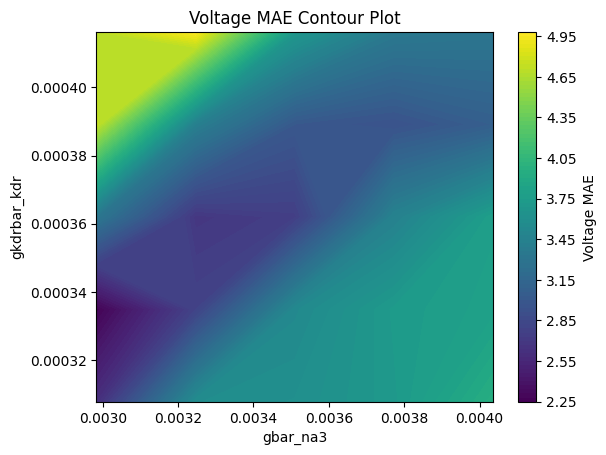

Smallest MAE values (gbar_na3, gbar_nap, V MAE): 
[[0.00298326 0.03086724 1.90908732]
 [0.00298326 0.03086724 1.96484591]
 [0.00298326 0.03086724 2.02478   ]
 [0.00298326 0.03359083 2.0883163 ]
 [0.00298326 0.03359083 2.13087388]
 [0.00298326 0.03359083 2.18739   ]]


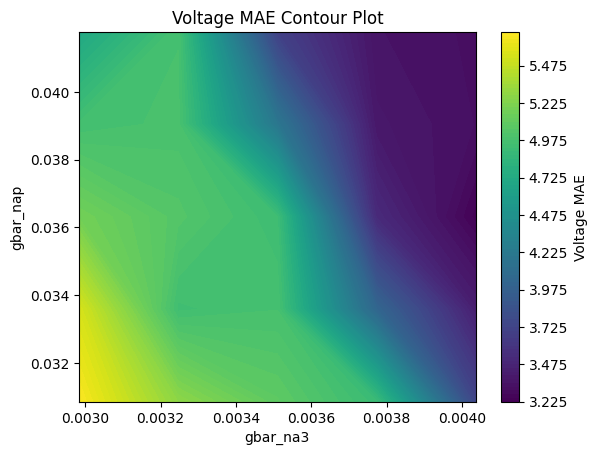

Smallest MAE values (gbar_na3, gmbar_im, V MAE): 
[[0.00298326 0.02250692 1.90908732]
 [0.00298326 0.02407717 1.96484591]
 [0.00298326 0.02093667 2.02478   ]
 [0.00298326 0.02407717 2.0883163 ]
 [0.00298326 0.02250692 2.13087388]
 [0.00298326 0.02093667 2.18739   ]]


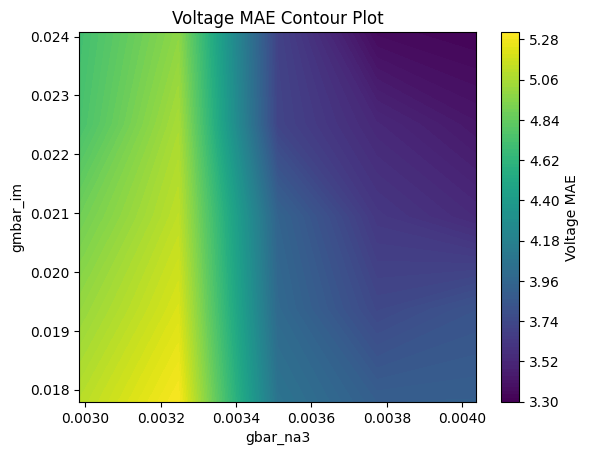

In [26]:
from act import ACTPlot as actplt

g_names = ["gbar_na3", "gkdrbar_kdr","gbar_nap","gmbar_im"]

for i in range(len(g_names)-1):
    actplt.plot_training_v_mae_contour_plot(
        module_final_folder,
        sim_par["CI_amps"], 
        sim_par["CI_delay"],
        sim_par["h_dt"],
        index1=0,
        index2=i+1,
        g_names=g_names,
        results_filename=f"{module_final_folder}/results/Voltage_MAE_Contour_Plot_{g_names[0]}_{g_names[i+1]}.png"
    )